In [1]:
import konlpy
import gensim
import sklearn
import seaborn

print(konlpy.__version__)
print(gensim.__version__)
print(sklearn.__version__)
print(seaborn.__version__)

0.5.2
4.1.2
1.0
0.11.2


In [2]:
import numpy as np
import seaborn as sns; 
import matplotlib.pyplot as plt

from konlpy.tag import Mecab
from gensim.models import Word2Vec

import re
import time

## STEP 1. 형태소 분석기 이용해서 명사 추출

In [3]:
mecab = Mecab()

def read_txt(file_name):
    data = []
    start = time.time()
    with open(f'./data/{file_name}', 'r') as file:
        while True:

            line = file.readline()
            line = re.sub("[ ]+" ," ", line)
            line = line.strip()
            if not line: 
                break

            words = mecab.morphs(line)
            words = [word for word in words if len(word) != 1]
            data += [words]

    end = time.time()
    print(f"{file_name} 걸린 시간 : {end - start}")
    return data

file_name = "synopsis_SF.txt"
data = read_txt(file_name)

synopsis_SF.txt 걸린 시간 : 0.29926466941833496


## STEP 2. 추출된 명사로 Embedding model

In [4]:
# tokenized에 담긴 데이터를 가지고 나만의 Word2Vec을 생성합니다. (Gensim 4.0 기준)
model = Word2Vec(data, vector_size=100, window=5, min_count=3, sg=1)  
model.wv.most_similar(positive=['SF'])

[('기술', 0.9984952211380005),
 ('작전', 0.9984567165374756),
 ('감염', 0.9984070062637329),
 ('소년', 0.998405933380127),
 ('흔적', 0.998389482498169),
 ('사이', 0.9983827471733093),
 ('이끄', 0.9983733296394348),
 ('돌아온', 0.9983516931533813),
 ('나타나', 0.9983433485031128),
 ('추적', 0.9983406662940979)]

## STEP 3. target, attribute 단어 셋 만들기

In [5]:
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['예술','일반','SF', '가족', '공연', '공포', '기타', '다큐멘터리', '드라마', '로맨스', '뮤지컬', '미스터리', '범죄', '역사', '서부극',
         '성인', '스릴러', '애니메이션', '액션', '모험', '전쟁', '코미디', '판타지']

- 공포(호러)가 없음..

In [6]:
# 전체 데이터 불러오기
data = []
for txt in genre_txt:
    data += read_txt(txt)
    
model = Word2Vec(data, vector_size=100, window=5, min_count=3, sg=1)  

synopsis_SF.txt 걸린 시간 : 0.3505430221557617
synopsis_family.txt 걸린 시간 : 0.11583781242370605
synopsis_show.txt 걸린 시간 : 0.10264301300048828
synopsis_horror.txt 걸린 시간 : 0.8362185955047607
synopsis_etc.txt 걸린 시간 : 0.6249887943267822
synopsis_documentary.txt 걸린 시간 : 2.026580810546875
synopsis_drama.txt 걸린 시간 : 5.35514760017395
synopsis_romance.txt 걸린 시간 : 1.4497029781341553
synopsis_musical.txt 걸린 시간 : 0.044480323791503906
synopsis_mystery.txt 걸린 시간 : 0.21955513954162598
synopsis_crime.txt 걸린 시간 : 0.4012606143951416
synopsis_historical.txt 걸린 시간 : 0.04509997367858887
synopsis_western.txt 걸린 시간 : 0.013108253479003906
synopsis_adult.txt 걸린 시간 : 0.6687607765197754
synopsis_thriller.txt 걸린 시간 : 0.5883181095123291
synopsis_animation.txt 걸린 시간 : 1.6880183219909668
synopsis_action.txt 걸린 시간 : 1.464958906173706
synopsis_adventure.txt 걸린 시간 : 0.24594402313232422
synopsis_war.txt 걸린 시간 : 0.10596013069152832
synopsis_comedy.txt 걸린 시간 : 1.4077987670898438
synopsis_fantasy.txt 걸린 시간 : 0.16605019569396973

## STEP 4. 장르별 WEAT 계산하기

In [7]:
# 코사인 유사도
def cos_sim(i, j):
    return np.dot(i, j.T)/(np.linalg.norm(i)*np.linalg.norm(j))

In [8]:
# 대표 단어 선정 : 유사도 높은 상위 10개
def similar_word_arr(model, genre_name):
    similar_words = model.wv.most_similar(positive=[genre_name])  # genre_name과 유사한 단어들을 상위 10개까지 가져옴
    similar_words = list(map(lambda x: x[0], similar_words))
    similar_arr = [model.wv[word] for word in similar_words]
    return similar_words, similar_arr


from collections import defaultdict
result = defaultdict()

for i in range(len(genre_name)):
    result[genre_name[i]] = similar_word_arr(model, genre_name[i])
result = dict(result)    

In [9]:
# 하나의 타겟 단어와 여러개의 attribute 단어들
def s(w, a, b):
    similar_tar_attr_01 = []
    for attr in a:
        similar_tar_attr_01 += [cos_sim(w[1], attr[1])]

    mean_similar_01 = np.mean(similar_tar_attr_01)

    similar_tar_attr_02 = []
    for attr in b:
        similar_tar_attr_02 += [cos_sim(w[1], attr[1])]

    mean_similar_02 = np.mean(similar_tar_attr_02)
    
    return mean_similar_01 - mean_similar_02

In [10]:
def weat_score(w1, w2, a, b):
    mean_s_01 = []
    for w in w1:
        mean_s_01 += [s(w, a, b)]
    mean01 = np.mean(mean_s_01)
    
    mean_s_02 = []
    for w in w2:
        mean_s_02 += [s(w, a, b)]
    mean02 = np.mean(mean_s_02)
    
    std = np.std(np.concatenate([mean_s_01, mean_s_02]))
    
    return (mean01 - mean02) / std

In [11]:
target_word_01, target_arr_01 = result[genre_name[0]]
target_word_02, target_arr_02 = result[genre_name[1]]


art_bias = []
normal_bias = []
nothing_bias = []

for i in range(2, len(result)):
    attr_word_01, attr_arr_01 = result[genre_name[i]]
    for j in range(i + 1, len(result)):
        attr_word_02, attr_arr_02 = result[genre_name[j]]
        
        weat = weat_score(target_arr_01, target_arr_02, attr_arr_01, attr_arr_02)
        if weat > 0.05:
            print(f"\"{genre_name[0]}\"는 \"{genre_name[i]}\"에 편향되어 있습니다. {weat}")
            art_bias += [genre_name[i]]
            print(f"\"{genre_name[1]}\"는 \"{genre_name[j]}\"에 편향되어 있습니다. {weat}")
            normal_bias += [genre_name[j]]
        elif weat < -0.05:
            print(f"\"{genre_name[0]}\" 장르는 \"{genre_name[j]}\" 장르에 편향되어 있습니다. {weat}")
            art_bias += [genre_name[j]]
            print(f"\"{genre_name[1]}\" 장르는 \"{genre_name[i]}\" 장르에 편향되어 있습니다. {weat}")
            normal_bias += [genre_name[i]]
        elif weat >= -0.05 and weat <= 0.05:
            print(f"\"{genre_name[0]}\" 장르는 편향되지 않은 장르입니다. {weat}")        
            nothing_bias += [genre_name[j]]

"예술" 장르는 "가족" 장르에 편향되어 있습니다. -0.8401680588722229
"일반" 장르는 "SF" 장르에 편향되어 있습니다. -0.8401680588722229
"예술" 장르는 "공연" 장르에 편향되어 있습니다. -0.8401680588722229
"일반" 장르는 "SF" 장르에 편향되어 있습니다. -0.8401680588722229
"예술" 장르는 "공포" 장르에 편향되어 있습니다. -0.8401679396629333
"일반" 장르는 "SF" 장르에 편향되어 있습니다. -0.8401679396629333
"예술" 장르는 "기타" 장르에 편향되어 있습니다. -0.8401679992675781
"일반" 장르는 "SF" 장르에 편향되어 있습니다. -0.8401679992675781
"예술" 장르는 "드라마" 장르에 편향되어 있습니다. -0.8401680588722229
"일반" 장르는 "SF" 장르에 편향되어 있습니다. -0.8401680588722229
"예술" 장르는 "로맨스" 장르에 편향되어 있습니다. -0.8401679992675781
"일반" 장르는 "SF" 장르에 편향되어 있습니다. -0.8401679992675781
"예술" 장르는 "뮤지컬" 장르에 편향되어 있습니다. -0.8401681780815125
"일반" 장르는 "SF" 장르에 편향되어 있습니다. -0.8401681780815125
"예술" 장르는 "미스터리" 장르에 편향되어 있습니다. -0.8401680588722229
"일반" 장르는 "SF" 장르에 편향되어 있습니다. -0.8401680588722229
"예술" 장르는 "범죄" 장르에 편향되어 있습니다. -0.8401681780815125
"일반" 장르는 "SF" 장르에 편향되어 있습니다. -0.8401681780815125
"예술" 장르는 "역사" 장르에 편향되어 있습니다. -0.8401681780815125
"일반" 장르는 "SF" 장르에 편향되어 있습니다. -0.8401681780815125
"예술" 장르는 "서부극" 

/tmp/ipykernel_211/3546691080.py:14: RuntimeWarning: invalid value encountered in float_scalars
  return (mean01 - mean02) / std


"예술" 장르는 "판타지" 장르에 편향되어 있습니다. -0.8401680588722229
"일반" 장르는 "SF" 장르에 편향되어 있습니다. -0.8401680588722229
"예술"는 "가족"에 편향되어 있습니다. 0.8401679992675781
"일반"는 "공연"에 편향되어 있습니다. 0.8401679992675781
"예술" 장르는 "공포" 장르에 편향되어 있습니다. -0.8401679992675781
"일반" 장르는 "가족" 장르에 편향되어 있습니다. -0.8401679992675781
"예술" 장르는 "기타" 장르에 편향되어 있습니다. -0.8401680588722229
"일반" 장르는 "가족" 장르에 편향되어 있습니다. -0.8401680588722229
"예술"는 "가족"에 편향되어 있습니다. 0.8401680588722229
"일반"는 "다큐멘터리"에 편향되어 있습니다. 0.8401680588722229
"예술"는 "가족"에 편향되어 있습니다. 0.8401680588722229
"일반"는 "드라마"에 편향되어 있습니다. 0.8401680588722229
"예술" 장르는 "로맨스" 장르에 편향되어 있습니다. -0.8401680588722229
"일반" 장르는 "가족" 장르에 편향되어 있습니다. -0.8401680588722229
"예술"는 "가족"에 편향되어 있습니다. 0.8401680588722229
"일반"는 "뮤지컬"에 편향되어 있습니다. 0.8401680588722229
"예술"는 "가족"에 편향되어 있습니다. 0.8401679992675781
"일반"는 "미스터리"에 편향되어 있습니다. 0.8401679992675781
"예술"는 "가족"에 편향되어 있습니다. 0.8401680588722229
"일반"는 "범죄"에 편향되어 있습니다. 0.8401680588722229
"예술"는 "가족"에 편향되어 있습니다. 0.8401680588722229
"일반"는 "역사"에 편향되어 있습니다. 0.8401680588722229
"예술"는 "가족"에

"예술" 장르는 "성인" 장르에 편향되어 있습니다. -0.8401680588722229
"일반" 장르는 "뮤지컬" 장르에 편향되어 있습니다. -0.8401680588722229
"예술"는 "뮤지컬"에 편향되어 있습니다. 0.8401681780815125
"일반"는 "애니메이션"에 편향되어 있습니다. 0.8401681780815125
"예술" 장르는 "모험" 장르에 편향되어 있습니다. -0.8401680588722229
"일반" 장르는 "뮤지컬" 장르에 편향되어 있습니다. -0.8401680588722229
"예술" 장르는 "전쟁" 장르에 편향되어 있습니다. -0.8401681780815125
"일반" 장르는 "뮤지컬" 장르에 편향되어 있습니다. -0.8401681780815125
"예술" 장르는 "코미디" 장르에 편향되어 있습니다. -0.8401679992675781
"일반" 장르는 "뮤지컬" 장르에 편향되어 있습니다. -0.8401679992675781
"예술" 장르는 "판타지" 장르에 편향되어 있습니다. -0.8401680588722229
"일반" 장르는 "뮤지컬" 장르에 편향되어 있습니다. -0.8401680588722229
"예술"는 "미스터리"에 편향되어 있습니다. 0.8401679992675781
"일반"는 "범죄"에 편향되어 있습니다. 0.8401679992675781
"예술"는 "미스터리"에 편향되어 있습니다. 0.8401679992675781
"일반"는 "역사"에 편향되어 있습니다. 0.8401679992675781
"예술"는 "미스터리"에 편향되어 있습니다. 0.8401679992675781
"일반"는 "서부극"에 편향되어 있습니다. 0.8401679992675781
"예술" 장르는 "성인" 장르에 편향되어 있습니다. -0.8401679992675781
"일반" 장르는 "미스터리" 장르에 편향되어 있습니다. -0.8401679992675781
"예술"는 "미스터리"에 편향되어 있습니다. 0.8401679992675781
"일반"는 "스릴러"에

In [12]:
len(genre_name)

23

In [13]:
# 예술 분야에 편향된 장르
set(art_bias) - set(normal_bias)

{'기타', '로맨스'}

In [14]:
# 일반 분야에 편향된 장르
set(normal_bias) - set(art_bias) 

{'SF', '다큐멘터리', '애니메이션'}

In [15]:
nothing_bias

[]

## STEP 5. 예술, 일반장르 편향성 및 시각화

In [16]:
np.random.seed(0)

# 한글 지원 폰트
sns.set(font='NanumGothic')

# 마이너스 부호 

plt.rcParams['axes.unicode_minus'] = False

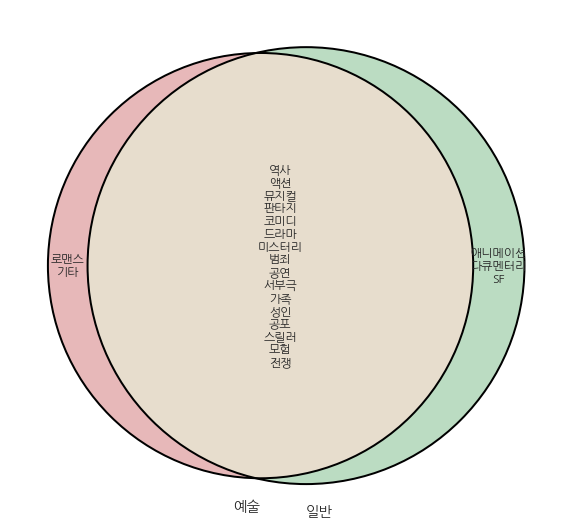

In [17]:
import matplotlib.pyplot as plt 
from matplotlib_venn import venn2, venn2_circles

plt.figure(figsize = (10, 10))
A = set(art_bias) 
B = set(normal_bias) 
v = venn2(subsets=[A, B], set_labels=('예술', '일반')) 
c = venn2_circles(subsets=[A, B], linestyle='solid')

v.get_label_by_id('100').set_text('\n'.join(map(str,A-B)))
v.get_label_by_id('110').set_text('\n'.join(map(str,A&B)))
v.get_label_by_id('010').set_text('\n'.join(map(str,B-A)))